# Preparation

We will need to install tesseract-ocr and download files to be used in training


In [2]:
# Install tesseract-ocr
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (26.2 MB/s)
debconf: unable to initia

In [3]:
# Download prerequisites
!git clone https://github.com/Swoosky/tesseract-retrain-for-nik.git

# Tesseract 4.1 used because tesstrain.sh will be used to train the ocr
!git clone -b '4.1' https://github.com/tesseract-ocr/tesseract.git

Cloning into 'tesseract-retrain-for-nik'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 813 (delta 2), reused 8 (delta 1), pack-reused 804
Receiving objects: 100% (813/813), 133.40 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (29/29), done.
Cloning into 'tesseract'...
remote: Enumerating objects: 45552, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 45552 (delta 5), reused 10 (delta 3), pack-reused 45532
Receiving objects: 100% (45552/45552), 50.95 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (35766/35766), done.


In [4]:
# Make tesstrain script runnable
!chmod 755 -R /content/tesseract/src/training/tesstrain.sh

In [5]:
# Create folder for output and temp
!mkdir output tmp

In [6]:
!cp /content/tesseract-retrain-for-nik/eng.traineddata /content/tesseract/tessdata

# Prepare Font
Get your font name and copy font file into `/content/tesseract-retrain-for-nik/fonts`

Code is not tested yet if used more than 1 font

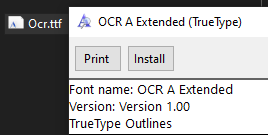

In [7]:
font_name = 'OCR A EXTENDED'

# Create .trainingdata
This will start training the ocr with the specified font

Output will be saved into tmp (later will be fine tuned)

`--maxpages 10` can be increased, untested

In [8]:
!rm -rf train/*
! /content/tesseract/src/training/tesstrain.sh --fonts_dir /content/tesseract-retrain-for-nik/fonts \
	--fontlist '{font_name}' \
	--lang eng \
	--linedata_only \
	--langdata_dir /content/tesseract-retrain-for-nik/langdata_lstm \
	--tessdata_dir /content/tesseract/tessdata \
  --training_text /content/tesseract-retrain-for-nik/nik.digits.training_text \
	--save_box_tiff \
	--maxpages 10 \
	--output_dir tmp


=== Starting training for language 'eng'
[Sun May 29 17:18:12 UTC 2022] /usr/bin/text2image --fonts_dir=/content/tesseract-retrain-for-nik/fonts --ptsize 12 --font=OCR A EXTENDED --outputbase=/tmp/font_tmp.iCza79NiDO/sample_text.txt --text=/tmp/font_tmp.iCza79NiDO/sample_text.txt --fontconfig_tmpdir=/tmp/font_tmp.iCza79NiDO
Rendered page 0 to file /tmp/font_tmp.iCza79NiDO/sample_text.txt.tif

=== Phase I: Generating training images ===
Rendering using OCR A EXTENDED
[Sun May 29 17:18:14 UTC 2022] /usr/bin/text2image --fontconfig_tmpdir=/tmp/font_tmp.iCza79NiDO --fonts_dir=/content/tesseract-retrain-for-nik/fonts --strip_unrenderable_words --leading=32 --xsize=3600 --char_spacing=0.0 --exposure=0 --outputbase=/tmp/eng-2022-05-29.tw9/eng.OCR_A_EXTENDED.exp0 --max_pages=10 --font=OCR A EXTENDED --ptsize 12 --text=/content/tesseract-retrain-for-nik/nik.digits.training_text
Rendered page 0 to file /tmp/eng-2022-05-29.tw9/eng.OCR_A_EXTENDED.exp0.tif
Rendered page 1 to file /tmp/eng-2022-05-

# Finetune

`--max_iterations 200` can be increased, untested

In [9]:
!combine_tessdata -e  /content/tesseract/tessdata/eng.traineddata eng.lstm

Extracting tessdata components from /content/tesseract/tessdata/eng.traineddata
Wrote eng.lstm
Version string:4.00.00alpha:eng:synth20170629:[1,36,0,1Ct3,3,16Mp3,3Lfys64Lfx96Lrx96Lfx512O1c1]
17:lstm:size=11689099, offset=192
18:lstm-punc-dawg:size=4322, offset=11689291
19:lstm-word-dawg:size=3694794, offset=11693613
20:lstm-number-dawg:size=4738, offset=15388407
21:lstm-unicharset:size=6360, offset=15393145
22:lstm-recoder:size=1012, offset=15399505
23:version:size=80, offset=15400517


In [10]:
%%shell

rm -rf output/* 
OMP_THREAD_LIMIT=16 lstmtraining \
	--continue_from eng.lstm \
	--model_output output/font_name \
	--traineddata  /content/tesseract/tessdata/eng.traineddata \
	--train_listfile /content/tmp/eng.training_files.txt \
	--max_iterations 200

Loaded file eng.lstm, unpacking...
Continuing from eng.lstm
Loaded 550/550 pages (1-550) of document tmp/eng.OCR_A_EXTENDED.exp0.lstmf
2 Percent improvement time=12, best error was 100 @ 0
At iteration 12/100/100, Mean rms=0.291%, delta=0.24%, char train=1.227%, word train=3.667%, skip ratio=0%,  New best char error = 1.227 Transitioned to stage 1 wrote best model:output/font_name1.227_12.checkpoint wrote checkpoint.

2 Percent improvement time=12, best error was 100 @ 0
At iteration 12/200/200, Mean rms=0.201%, delta=0.12%, char train=0.614%, word train=1.833%, skip ratio=0%,  New best char error = 0.614 wrote best model:output/font_name0.614_12.checkpoint wrote checkpoint.

Finished! Error rate = 0.614


# Finish training

Output will be saved in `/content/output`

In [11]:
%%shell

lstmtraining --stop_training \
	--continue_from output/font_name_checkpoint \
	--traineddata /content/tesseract-retrain-for-nik/eng.traineddata \
	--model_output output/out.traineddata

Loaded file output/font_name_checkpoint, unpacking...


Download the traineddata

In [ ]:
from google.colab import files

files.download('/content/output/out.traineddata')

Run this code if you want to download the whole output folder

In [1]:
# import shutil
# from google.colab import files
# from datetime import date

# out_filename = "output" + str(date.today()

# shutil.make_archive(out_filename , "zip", '/content/output')

# files.download(out_filename)

FileNotFoundError: ignored

# How to use the traineddata?

## Install the traineddata
Copy the `out.traineddata` into `tessdata` folder inside tesseract-ocr installation folder.

You can rename `out` into something else, that name will be used when calling the tesseract command.

<br>

## Using the traineddata
1. By using tesseract-ocr directly

  ```
   tesseract.exe img_path output_path -l out
  ```

2. By using pytesseract

  check out the code below

In [13]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 33.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Copy the output into installed tesseract-ocr folder
!cp /content/output/out.traineddata /usr/share/tesseract-ocr/4.00/tessdata

PROVINSI BALI

 

KOTA DENPASAR

NIK :9289092910328280
Nama : RIMA JOSHUA
Tempat/Tgl Lahir : CHFOXVSY, 07-04-1990
Jenis Kelamin : LAKI-LAKI Gol. Darah : B
Alamat : JL. HAFJI JXUNXVL 5

RTIRW : 8271237

KellDesa ~~ :DENPASAR

Kecamatan : DENPASAR UTARA
Agama : HINDU
Status Perkawinan : BELUM KAWIN
Pekerjaan : JXMUQMWHGDAD KOTADENPASAR
Kewarganegaraan : WNI 21122081

Berlaku Hingga

: SEUMUR HIDUP



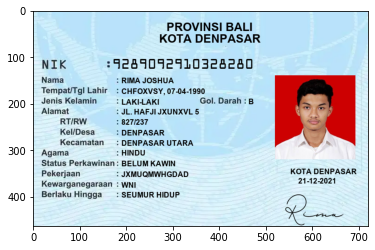

In [4]:
import re
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/tesseract-retrain-for-nik/sample_ktp.png'

# Open the image
img = Image.open(img_path)
plt.imshow(img)

# For better result, image should be cropped into the part needed only
result = pytesseract.image_to_string(img, lang="out")
print(result)